In [2]:
## Load necessary packages

# Default python packages
import os
import random
import logging
import itertools
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from PIL import ImageFile

# Python Numpy Stack
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Pytorch tools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import vgg16, VGG16_Weights


import warnings
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
"""This is equivalent to any config.py file. On kaggle this class is used to hold
all the configurations and their default values to be used throughout the project.
"""

class Config:
    use_pretrained = False
    VER = 3
    SEED = 1992
    CUDA_AVAILABLE = False #  gpu or cpu? to be set later
    DEVICE = None # based on CUDA_AVAILABLE
    DATA_DIR = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/")
    OUTPUT_DIR = Path("Output")
    LOGS_DIR = Path(OUTPUT_DIR, "logs")
    MODELS_DIR = Path(OUTPUT_DIR, f"VGG16_ver_{VER}")
    LOGS_DIR.mkdir(parents=True, exist_ok=True)
    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    LOAD_TOKENS_FROM = None
    LOAD_MODEL_FROM = None
    DOWNLOADED_MODEL_PATH = None

In [4]:
# Initializing a logger function
def initialize_logger(log_file: str = Path(Config.LOGS_DIR, "info.log")):

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(
        logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    )
    
    file_handler = logging.FileHandler(filename=log_file)
    file_handler.setFormatter(
        logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    )
    
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

Config.logger = initialize_logger()

In [5]:
Config.CUDA_AVAILABLE = torch.cuda.is_available()
Config.DEVICE = torch.device("cuda" if Config.CUDA_AVAILABLE else "cpu")
Config.logger.info(f"We are using {Config.DEVICE}")

2023-05-07 05:47:30,639 - __main__ - INFO - We are using cuda


In [6]:
# https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

def set_seed(seed: int = Config.SEED) -> None:
    """Seed all random number generators."""
    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    
    # set fixed value for python built-in pseudo-random generator
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    Config.logger.info(f"Using Seed Number: {seed}")


set_seed()

2023-05-07 05:47:30,656 - __main__ - INFO - Using Seed Number: 1992


In [7]:
""" 
The classes below tracks different parameters to be used through out the project.
The idea is to make a change only here and not all the part where these
variables can be used.
"""

class FilePaths:
    train_dir = Path(Config.DATA_DIR, "train")
    test_dir = Path(Config.DATA_DIR, "test")
    valid_dir = Path(Config.DATA_DIR, "val")
    
class ModelParams:
    OUTPUT_SIZE = 2
    model_name = "vgg16"



class DataLoaderParams:

    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 16
    train_loader = {
            "batch_size": TRAIN_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": True,
            "shuffle": True,
            "collate_fn": None
    }
    
    valid_loader = {
            "batch_size": VALID_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": False,
            "drop_last": False,
            "shuffle": False,
            "collate_fn": None
    }

    test_loader = {
            "batch_size": VALID_BATCH_SIZE,
            "num_workers": 4,
            "pin_memory": True,
            "drop_last": False,
            "shuffle": True,
            "collate_fn": None
    }
        

class GlobalTrainParams:
    debug: bool = False
    epochs: int = 12


class CriterionParams:
    loss_func = "CrossEntropyLoss"


class OptimizerParams:
    optimizer_name = "Adam"
    lr = [1e-4, 5e-3, 3e-5, 2.5e-5, 2.5e-6, 2.5e-6, 2.5e-7]


In [8]:
FILES = FilePaths()
LOADER_PARAMS = DataLoaderParams()
TRAIN_PARAMS = GlobalTrainParams()
CRITERION_PARAMS = CriterionParams()
OPTIMIZER_PARAMS = OptimizerParams()
MODEL_PARAMS = ModelParams()

In [9]:
# Define data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
train_data = datasets.ImageFolder(FILES.train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(FILES.valid_dir, transform=train_transform)
test_data = datasets.ImageFolder(FILES.test_dir, transform = test_transform)

print("Number of Training Data: {}".format(len(train_data)))
print("Number of Testing Data: {}".format(len(test_data)))
print("Number of Validating Data: {}".format(len(valid_data)))

Number of Training Data: 5216
Number of Testing Data: 624
Number of Validating Data: 16


In [11]:
all_data = ConcatDataset([train_data, valid_data])

In [12]:
# Split train_data into train and validation sets
train_data, valid_data = train_test_split(all_data, test_size=0.2, random_state=42)

print("Number of Training Data: {}".format(len(train_data)))
print("Number of Testing Data: {}".format(len(test_data)))
print("Number of Validating Data: {}".format(len(valid_data)))

Number of Training Data: 4185
Number of Testing Data: 624
Number of Validating Data: 1047


In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=LOADER_PARAMS.train_loader["batch_size"])
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=LOADER_PARAMS.valid_loader["batch_size"])
test_loader = torch.utils.data.DataLoader(test_data, LOADER_PARAMS.test_loader["batch_size"], shuffle=LOADER_PARAMS.test_loader["shuffle"])

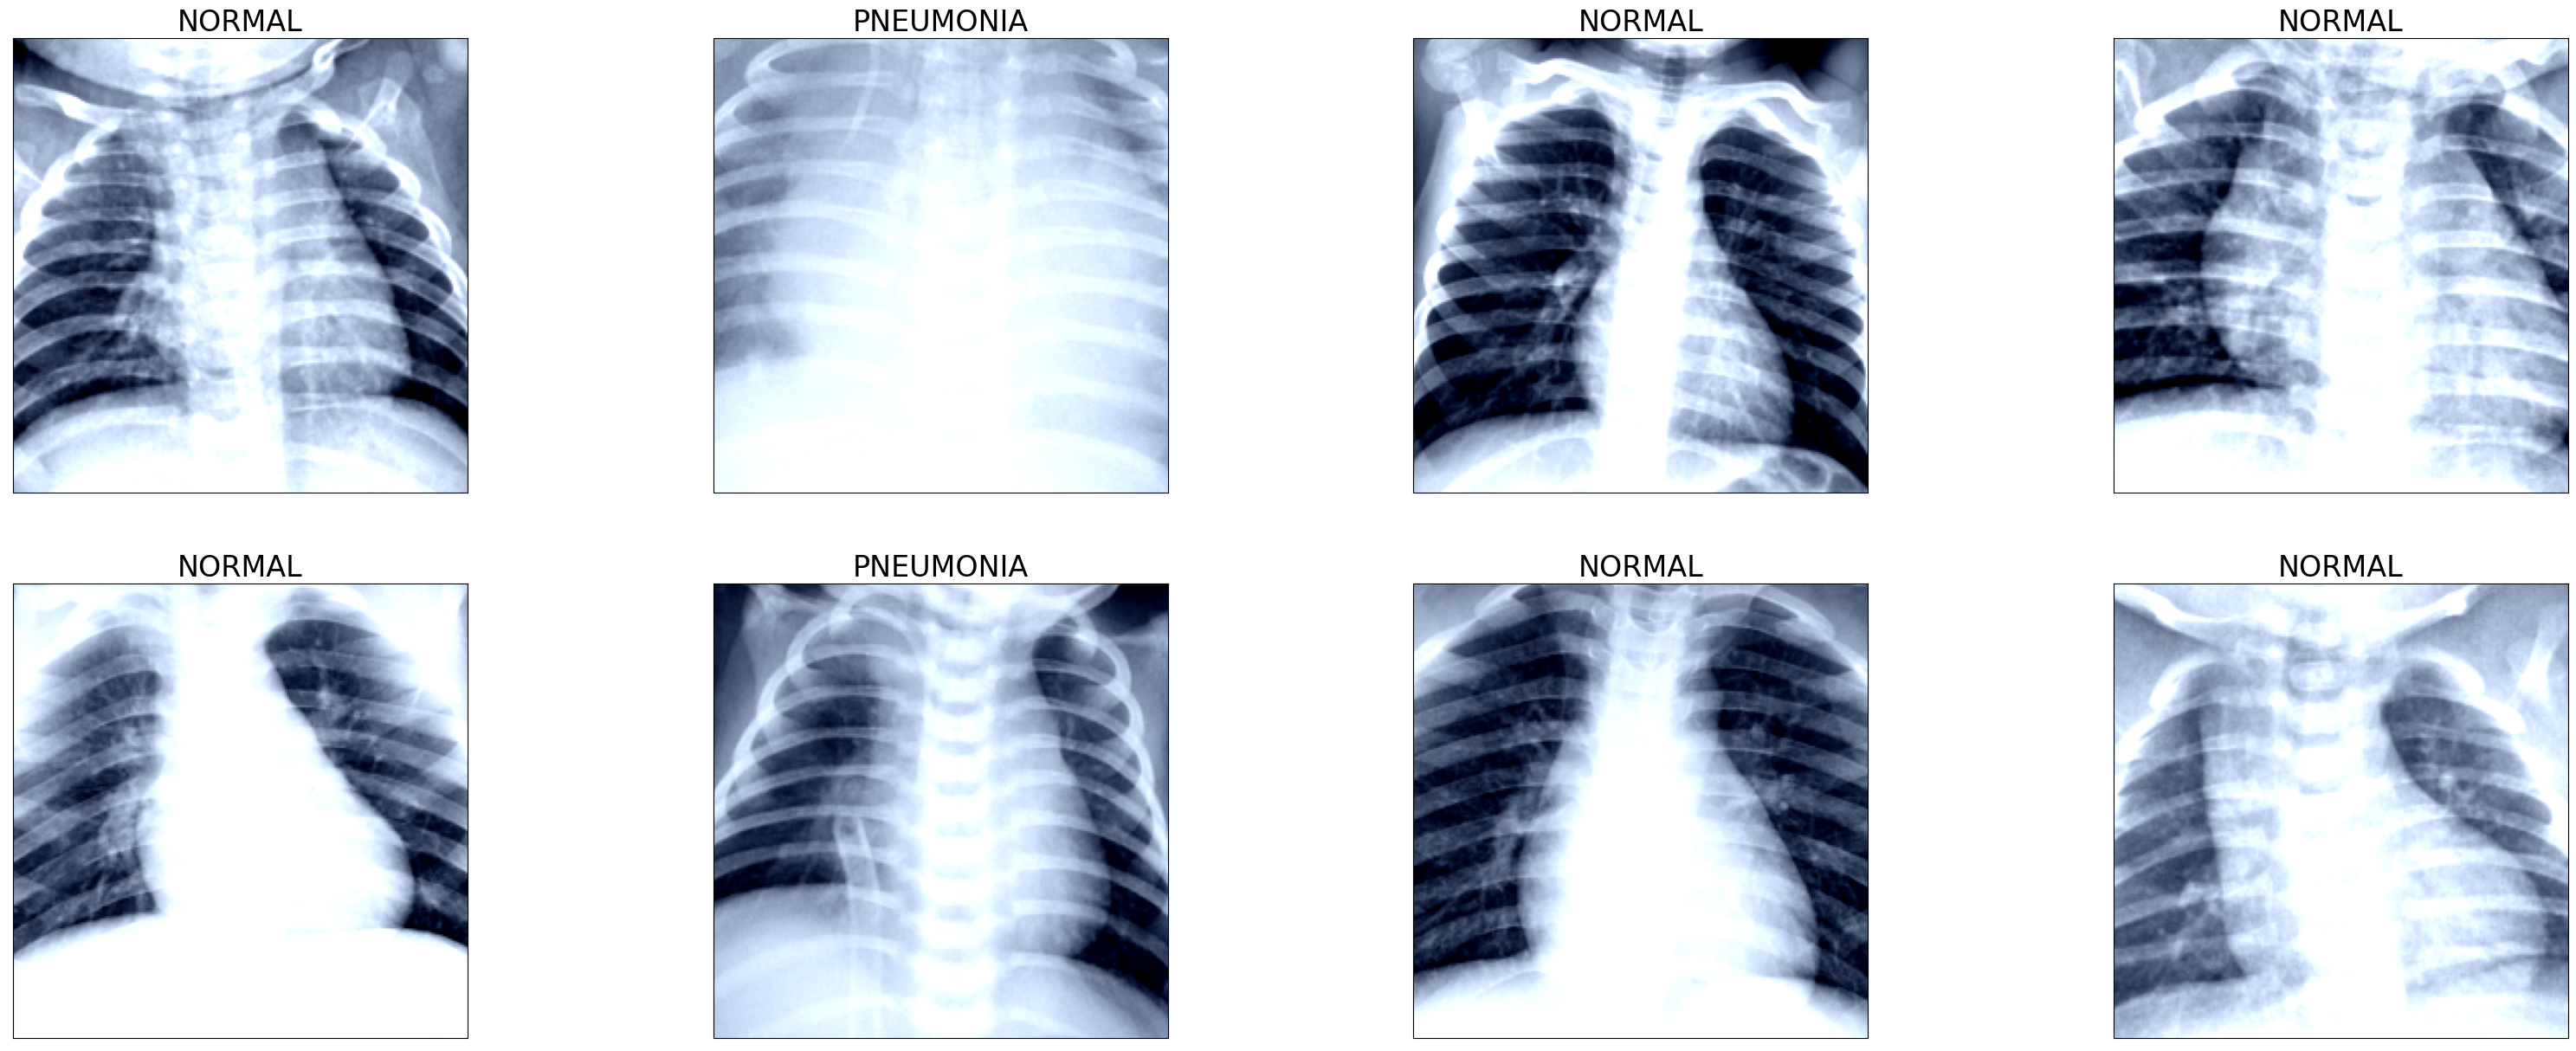

In [14]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = True if torch.cuda.is_available() else False
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(40, 15))
for idx in np.arange(8):
    ax = fig.add_subplot(2, int(8/2), idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img,cmap="gray")
    ax.set_title(test_data.classes[labels[idx].item()], fontsize=24)

In [15]:
## Base VGG Architecture

class VGG(nn.Module):
    def __init__(self, features, output_size):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_size)
            
            
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.classifier(x)
        
        return x

In [16]:
vgg16_config = [64, 64, "M", 128, 128, "M", 256, 256, 
                "M", 512, 512, 512, "M", 512, 512]

In [17]:
def get_vgg_layers(config):
    
    layers = list()
    in_channels = 3
    
    for c in config:
        
        assert c == "M" or isinstance(c, int)
        
        if c == "M":
            layers = layers + [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, 3, 1)
            layers = layers + [conv2d, nn.ReLU(inplace=True)]
            in_channels = c
    return nn.Sequential(*layers)

In [18]:
vgg_features = get_vgg_layers(vgg16_config)

In [19]:
output_size = ModelParams.OUTPUT_SIZE
use_pretrained = Config.use_pretrained
if use_pretrained:
    from torchvision import datasets, models, transforms
    from torchvision.models import vgg16, VGG16_Weights
    # Load pre-trained vgg16 model
    vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

    # Freeze all layers except the last one
    for param in vgg16.parameters():
        param.requires_grad = False

    num_ftrs = vgg16.classifier[-1].in_features
    vgg16.classifier[-1] = nn.Linear(num_ftrs, 2)
else:
    vgg16 = VGG(features=vgg_features, output_size=output_size)

In [20]:
if Config.CUDA_AVAILABLE:
    vgg16 = vgg16.cuda()

In [21]:
# Select appropriate criterion
if CRITERION_PARAMS.loss_func == "CrossEntropyLoss":
    criterion = nn.CrossEntropyLoss()

# Select appropriate optimizer
if OPTIMIZER_PARAMS.optimizer_name == "Adam":
    optimizer = optim.Adam(vgg16.parameters(), lr=OPTIMIZER_PARAMS.lr[0])
if OPTIMIZER_PARAMS.optimizer_name == "SGD":
    optimizer = optim.SGD(vgg16.parameters(), lr=OPTIMIZER_PARAMS.lr[0])

In [22]:
n_epochs = TRAIN_PARAMS.epochs

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    train_correct = 0
    valid_loss = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    vgg16.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            
            if train_on_gpu:
                img = img.cuda()
                label = label.cuda()
            
            optimizer.zero_grad()
            
            predicted_label = vgg16(img)
            loss = criterion(predicted_label, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(predicted_label.data, 1)
            train_correct += (predicted == label).sum().item()
            train_total += label.size(0)
            tepoch.set_postfix(loss=train_loss/len(train_loader))
    
    vgg16.eval()
    
    with tqdm(valid_loader, unit="batch") as tepoch:
        for img, label in tepoch:
            
            if train_on_gpu:
                img = img.cuda()
                label = label.cuda()
            
            predicted_label = vgg16(img)
            loss = criterion(predicted_label, label)
            
            valid_loss += loss.item()
            _, predicted = torch.max(predicted_label.data, 1)
            valid_correct += (predicted == label).sum().item()
            valid_total += label.size(0)
            tepoch.set_postfix(loss=valid_loss/len(valid_loader))
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = 100 * train_correct / train_total
    train_accs.append(train_acc)
    
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    valid_acc = 100 * valid_correct / valid_total
    valid_accs.append(valid_acc)
    
    print(f"Epoch: {e+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% \
          Valid Loss: {valid_loss:.4f} Valid Acc: {valid_acc:.2f}%")
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(vgg16.state_dict(), "vgg16_.pth")
        print("Saving Best Model")

100%|██████████| 66/66 [00:04<00:00, 13.61batch/s, loss=0.509] 


Epoch: 1 Train Loss: 0.5574 Train Acc: 74.55%           Valid Loss: 0.5092 Valid Acc: 72.30%
Validation Loss Decreased From inf to 0.509220891829693
Saving Best Model


100%|██████████| 66/66 [00:04<00:00, 16.20batch/s, loss=0.496] 


Epoch: 2 Train Loss: 0.4875 Train Acc: 75.77%           Valid Loss: 0.4964 Valid Acc: 77.36%
Validation Loss Decreased From 0.509220891829693 to 0.4963986726872849
Saving Best Model


100%|██████████| 66/66 [00:04<00:00, 16.08batch/s, loss=0.404] 


Epoch: 3 Train Loss: 0.4458 Train Acc: 80.07%           Valid Loss: 0.4041 Valid Acc: 82.81%
Validation Loss Decreased From 0.4963986726872849 to 0.4041376922166709
Saving Best Model


100%|██████████| 66/66 [00:04<00:00, 16.17batch/s, loss=0.4]   


Epoch: 4 Train Loss: 0.4076 Train Acc: 81.77%           Valid Loss: 0.3999 Valid Acc: 82.14%
Validation Loss Decreased From 0.4041376922166709 to 0.39987202688600076
Saving Best Model


100%|██████████| 66/66 [00:04<00:00, 16.04batch/s, loss=0.364] 


Epoch: 5 Train Loss: 0.3854 Train Acc: 83.30%           Valid Loss: 0.3642 Valid Acc: 84.62%
Validation Loss Decreased From 0.39987202688600076 to 0.36418089789874625
Saving Best Model


100%|██████████| 66/66 [00:04<00:00, 16.23batch/s, loss=0.383] 


Epoch: 6 Train Loss: 0.3621 Train Acc: 84.54%           Valid Loss: 0.3827 Valid Acc: 83.67%


100%|██████████| 66/66 [00:04<00:00, 16.19batch/s, loss=0.389] 


Epoch: 7 Train Loss: 0.3479 Train Acc: 85.07%           Valid Loss: 0.3887 Valid Acc: 84.15%


100%|██████████| 66/66 [00:04<00:00, 16.16batch/s, loss=0.398] 


Epoch: 8 Train Loss: 0.3346 Train Acc: 85.69%           Valid Loss: 0.3976 Valid Acc: 83.48%


100%|██████████| 66/66 [00:04<00:00, 16.09batch/s, loss=0.459] 


Epoch: 9 Train Loss: 0.3118 Train Acc: 86.93%           Valid Loss: 0.4592 Valid Acc: 83.86%


100%|██████████| 66/66 [00:04<00:00, 16.03batch/s, loss=0.427] 


Epoch: 10 Train Loss: 0.2958 Train Acc: 87.48%           Valid Loss: 0.4266 Valid Acc: 83.95%


100%|██████████| 66/66 [00:04<00:00, 16.07batch/s, loss=0.49]  


Epoch: 11 Train Loss: 0.2801 Train Acc: 88.67%           Valid Loss: 0.4902 Valid Acc: 83.19%


100%|██████████| 66/66 [00:04<00:00, 16.21batch/s, loss=0.514]

Epoch: 12 Train Loss: 0.2541 Train Acc: 89.77%           Valid Loss: 0.5137 Valid Acc: 83.57%


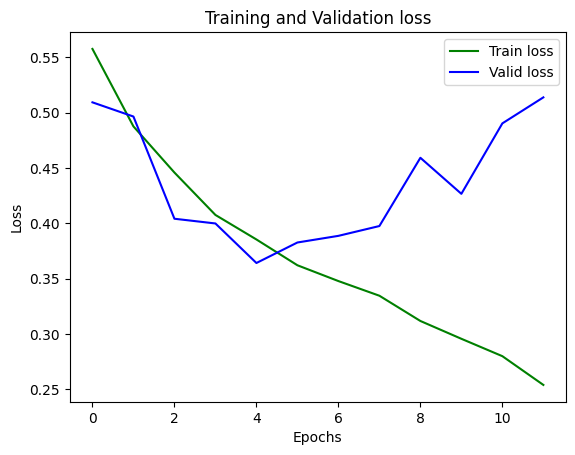

In [23]:
epochs = range(0, n_epochs)
plt.plot(epochs, train_losses, 'g', label='Train loss')
plt.plot(epochs, valid_losses, 'b', label='Valid loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

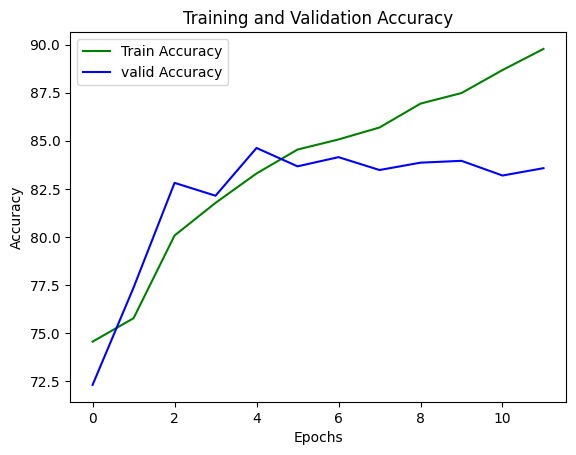

In [24]:
plt.plot(epochs, train_accs, 'g', label='Train Accuracy')
plt.plot(epochs, valid_accs, 'b', label='valid Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
correct = 0
total = 0


# set model to evaluation mode
vgg16.eval()

# loop through test_loader and compute predictions and true labels
preds = []
true_labels = []
with torch.no_grad(), tqdm(total=len(test_loader)) as pbar:
    for images, labels in test_loader:
        if train_on_gpu:
            images = images.cuda()
            labels = labels.cuda()
        output = vgg16(images)
        _, preds_tensor = torch.max(output, 1)
        predictions = preds_tensor.cpu().numpy()
        correct += (predictions == labels.cpu().numpy()).sum().item()
        total += labels.size(0)
        preds.extend(preds_tensor.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        pbar.update(1)

# calculate testing accuracy
accuracy = 100 * correct / total
print(f"Testing Accuracy: {accuracy:.2f}%")

# calculate precision, recall, and f1-score
report = classification_report(true_labels, preds, target_names=["Normal", "Pneumonia"])
print(report)

100%|██████████| 39/39 [00:14<00:00,  2.76it/s]

Testing Accuracy: 76.92%
              precision    recall  f1-score   support

      Normal       0.91      0.43      0.58       234
   Pneumonia       0.74      0.97      0.84       390

    accuracy                           0.77       624
   macro avg       0.82      0.70      0.71       624
weighted avg       0.80      0.77      0.74       624



In [30]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Paired):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

624 624


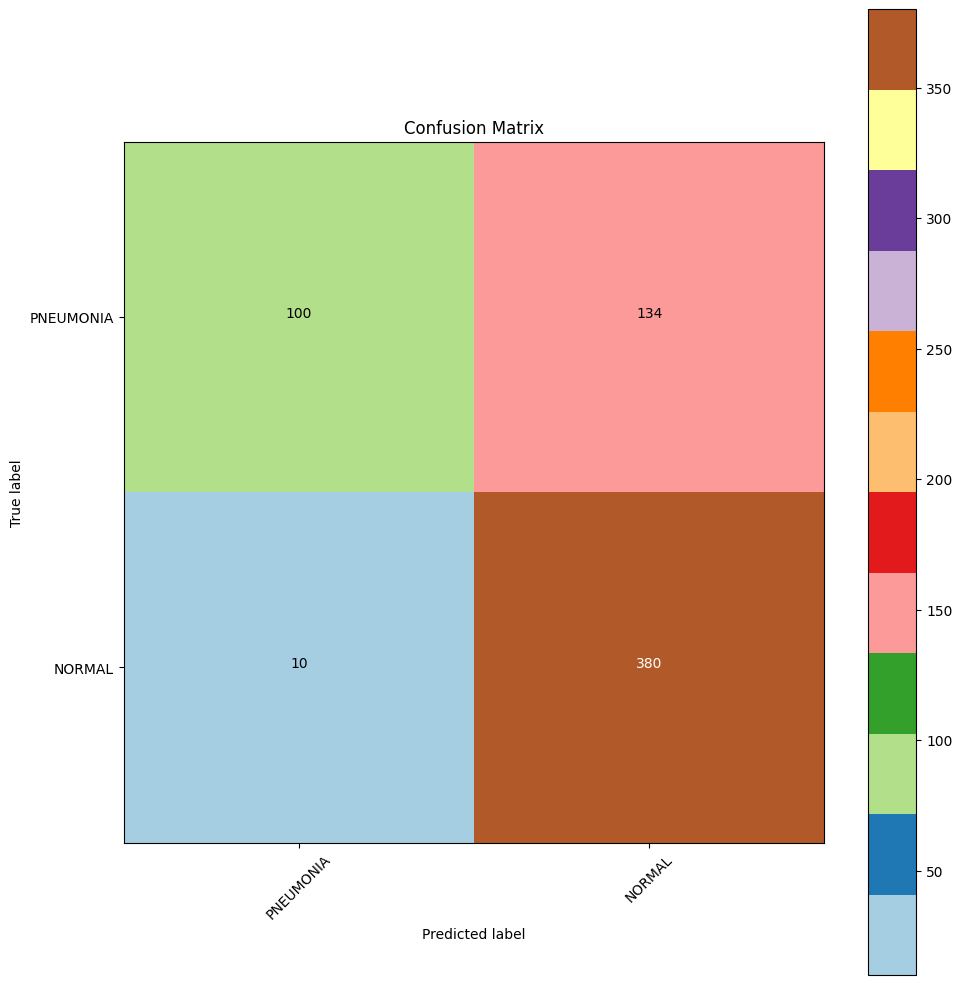

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print(len(true_labels), len(preds))
cm = confusion_matrix(true_labels, preds)
target_names = ["PNEUMONIA", "NORMAL"]
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

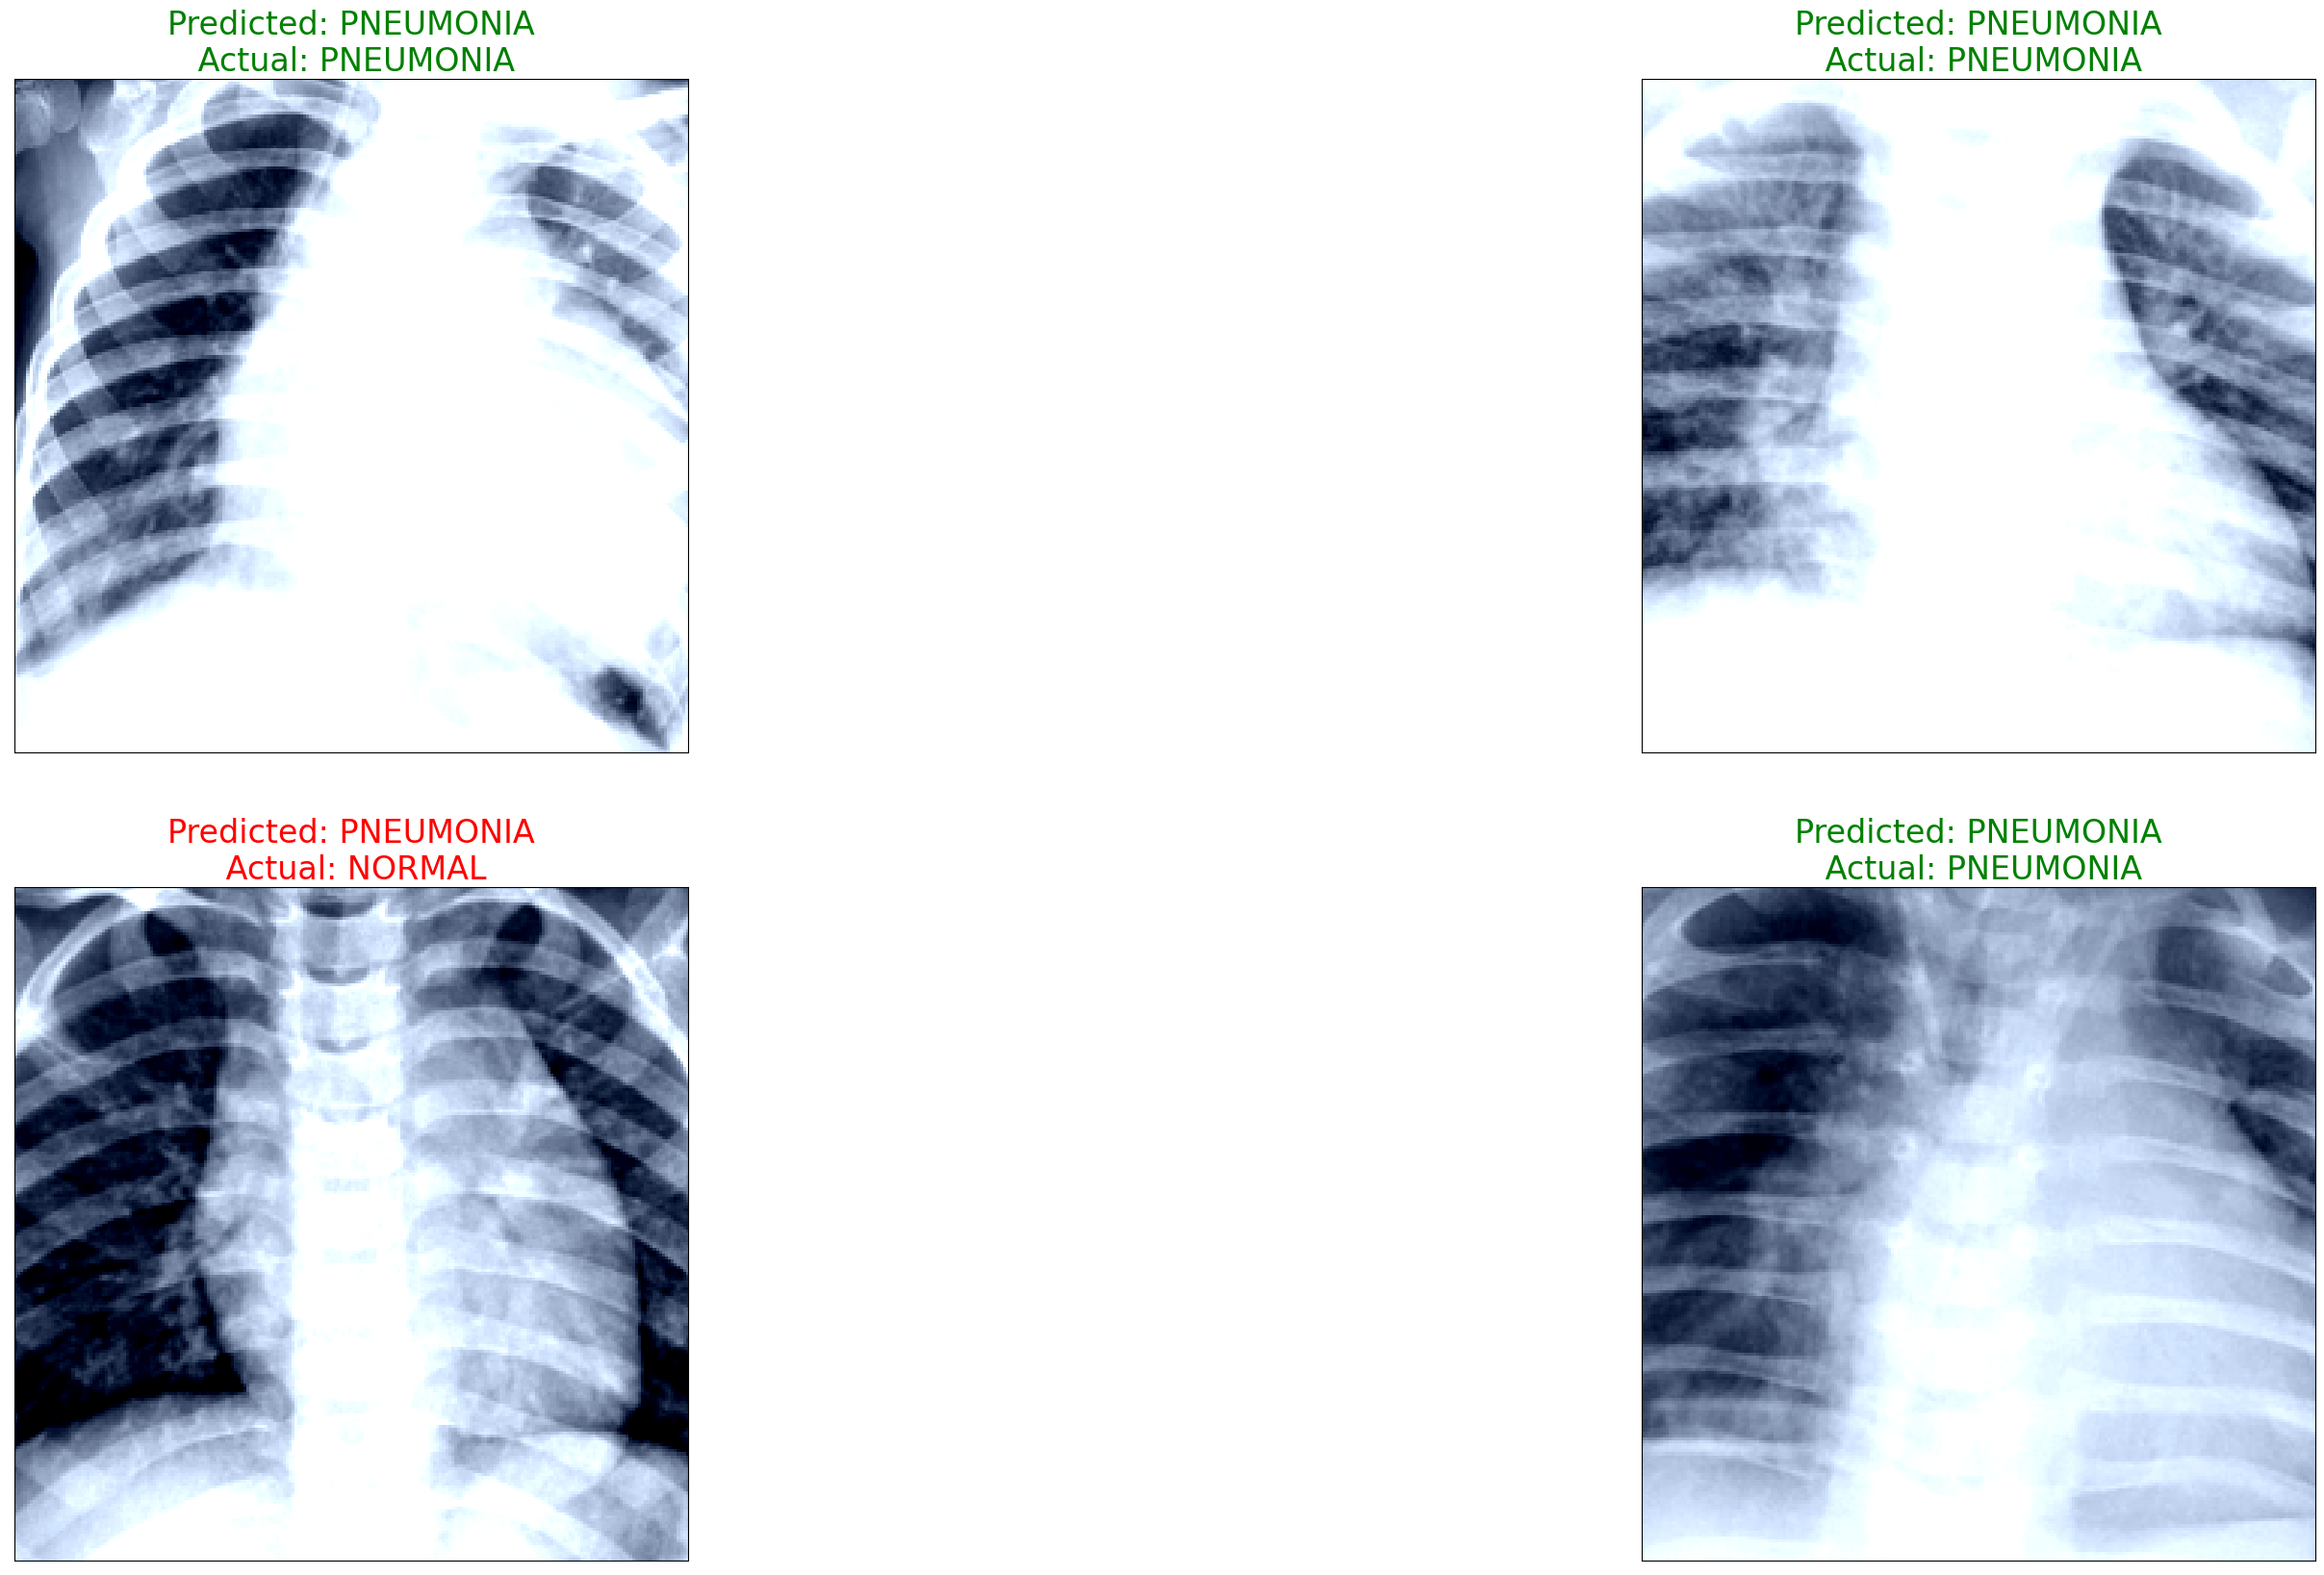

In [34]:
mapping = {
    1: "PNEUMONIA",
    0: "NORMAL"
}

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())



# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(40, 20))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(4/2), idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    img = img.reshape((224,224, 3))
    plt.imshow(img, cmap="gray")
    ax.set_title("Predicted: {}\n Actual: {}".format(mapping[preds[idx].item()],
                                  mapping[labels[idx].item()]),
                 fontsize=24,
                 color=("green" if preds[idx]==labels[idx].item() else "red")) 

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

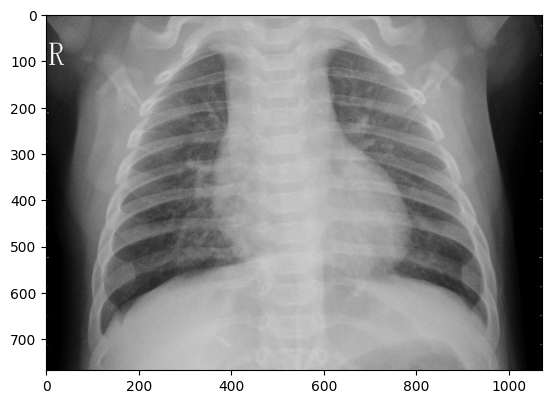

In [36]:
from PIL import Image
image = Image.open(str('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')).convert("RGB")
plt.imshow(image, cmap="gray")

In [37]:
from torchvision import datasets, models, transforms
from torchvision.models import vgg16, VGG16_Weights
# Load pre-trained vgg16 model
vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

# Freeze all layers except the last one
for param in vgg16.parameters():
    param.requires_grad = False

num_ftrs = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_ftrs, 2)
vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.9MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the  conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(vgg16.features.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 13
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vgg16.to(device)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [40]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

13
torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])


In [41]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


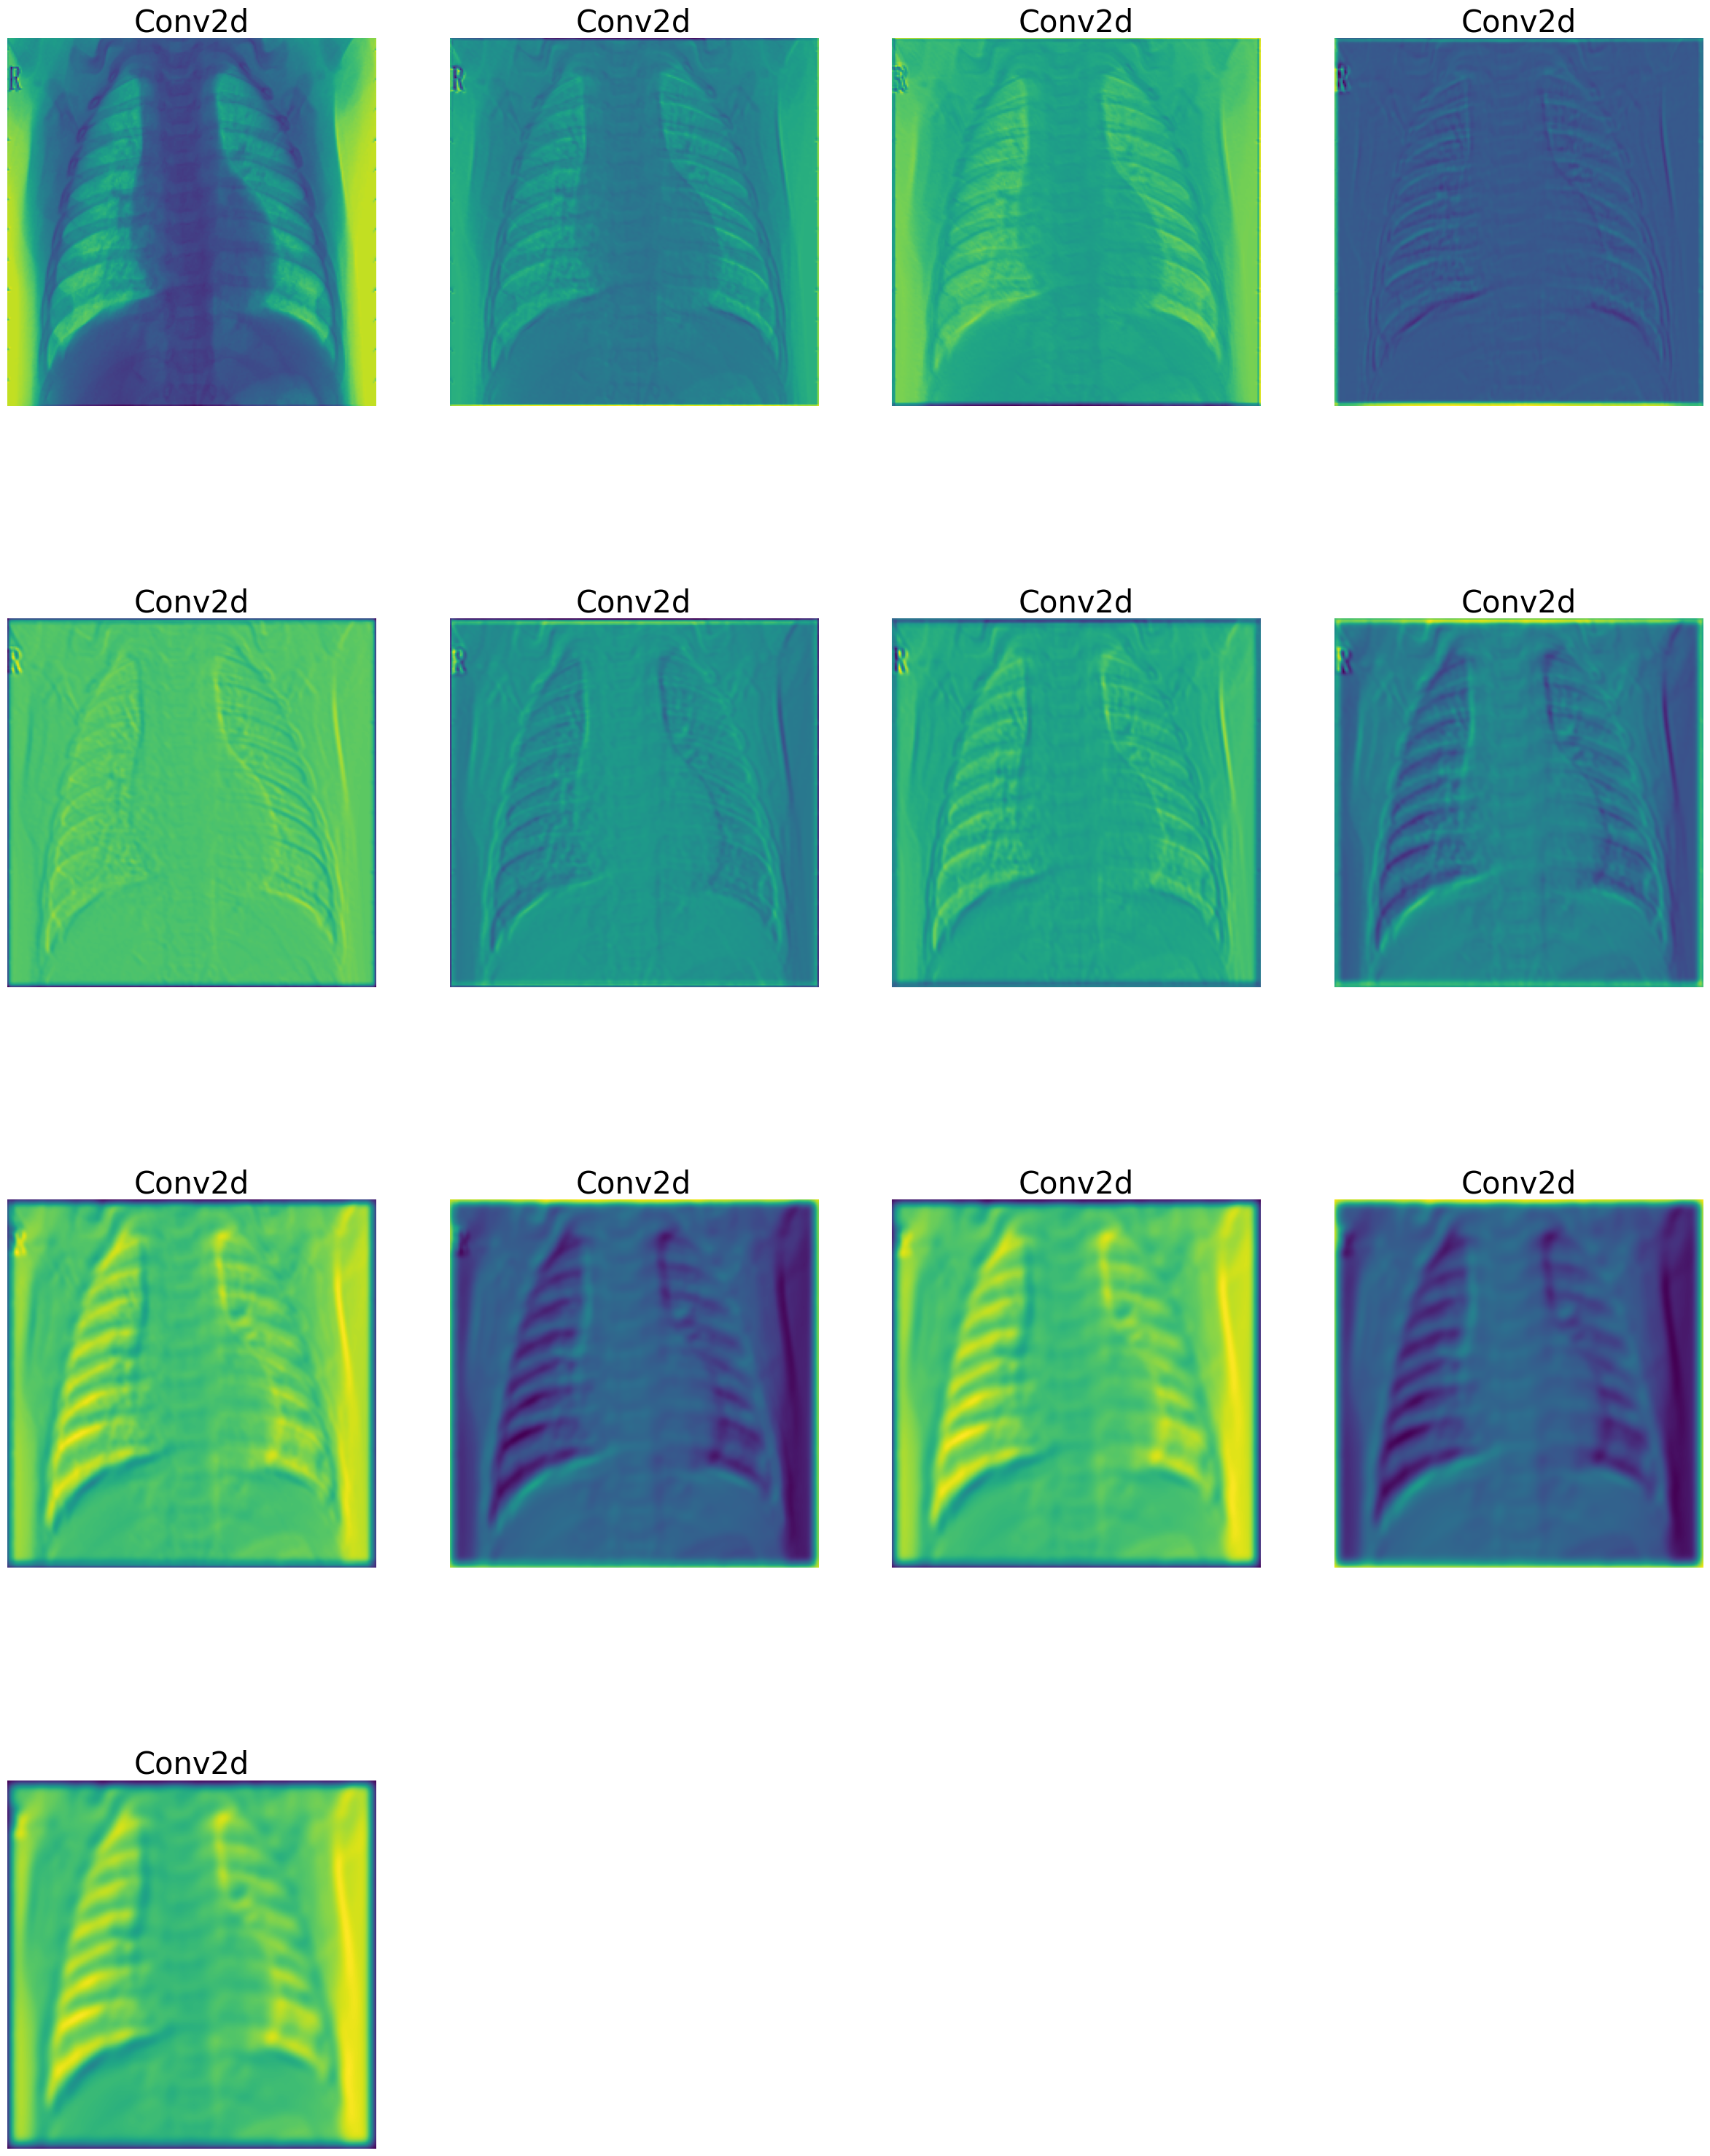

In [42]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')